In [15]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import math
import cartopy.crs as ccrs
import cartopy.feature as cf

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
def load_all_models(model_name):
    tas_anomaly_hist = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_historical.nc')
    tas_anomaly_ssp126 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp126.nc')
    tas_anomaly_ssp245 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp245.nc')
    tas_anomaly_ssp370 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp370.nc')
    tas_anomaly_ssp585 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp585.nc')
    tas_anomalies = [tas_anomaly_hist,tas_anomaly_ssp126,tas_anomaly_ssp245,tas_anomaly_ssp370,tas_anomaly_ssp585]
    return tas_anomalies

In [3]:
BCC_tas_anomalies = load_all_models('BCC-CSM2-MR')
#WACCM_tas_anomalies = load_all_models('CESM2-WACCM')

In [4]:
BCC_tas_anomalies[0]

<xarray.Dataset>
Dimensions:    (lat: 160, lon: 320, time: 10950)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
  * time       (time) object 1981-01-01 12:00:00 ... 2010-12-31 12:00:00
    dayofyear  (time) int64 ...
Data variables:
    tas        (time, lat, lon) float32 ...

In [5]:
tas_anomaly_hist = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_ACCESS-CM2_historical.nc')
tas_anomaly_ssp126 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_ACCESS-CM2_ssp126.nc')
tas_anomaly_ssp245 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_ACCESS-CM2_ssp245.nc')
tas_anomaly_ssp370 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_ACCESS-CM2_ssp370.nc')
tas_anomaly_ssp585 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_ACCESS-CM2_ssp585.nc')
tas_anomalies = [tas_anomaly_hist,tas_anomaly_ssp126,tas_anomaly_ssp245,tas_anomaly_ssp370,tas_anomaly_ssp585]

/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [6]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [7]:
def alaska_mean(ds):
    lat_slice = ds.sel(lat=slice(60,71))
    ak_slice = lat_slice.sel(lon=slice(193,219))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims)

In [8]:
gmsts = []
models = ['historical','ssp126','ssp245','ssp370','ssp585',]
for m in tas_anomalies:
    gmst = global_mean(m)
    gmsts.append(gmst)

In [9]:
akmsts = []
models = ['historical','ssp126','ssp245','ssp370','ssp585',]
for m in tas_anomalies:
    akmst = alaska_mean(m)
    akmsts.append(akmst)

In [ ]:
print(len(akmsts))

In [10]:
tas_anomaly_hist['tas']

<xarray.DataArray 'tas' (time: 10957, lat: 144, lon: 192)>
[302939136 values with dtype=float32]
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2010-12-31T12:00:00
    dayofyear  (time) int64 ...

In [11]:
def find_avg_annomaly(msts):
    model_ann_avgs = []
    for i in range(1,len(msts)):
        annual_avgs = []
        for year in np.arange(2020,2100):
            slicem = msts[i].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
            meantemp = slicem.mean('time')
            yr_i = year-2020
            annual_avgs.append(meantemp['tas'])
        model_ann_avgs.append(annual_avgs)
    
    return model_ann_avgs

In [13]:
avg_annomaly = find_avg_annomaly(gmsts)

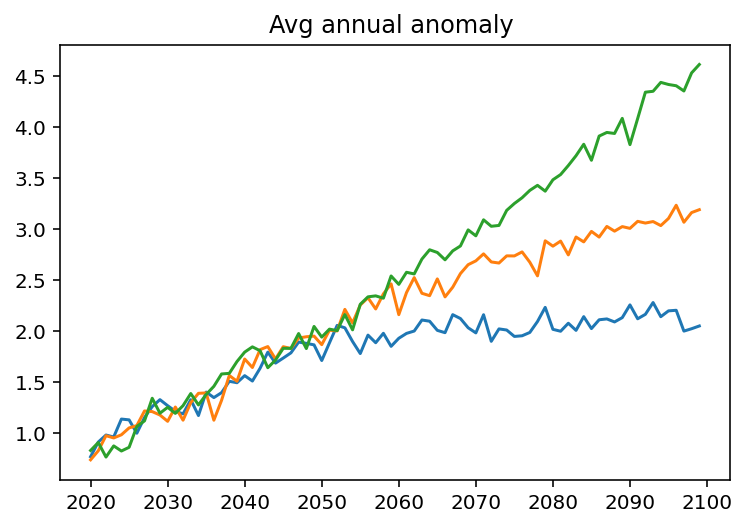

In [14]:
plt.figure()
for i in range(len(avg_annomaly)):
    #print(avg_annomaly[i])
    plt.plot(np.arange(2020,2100),avg_annomaly[i])
plt.title('Avg annual anomaly ')
plt.show()

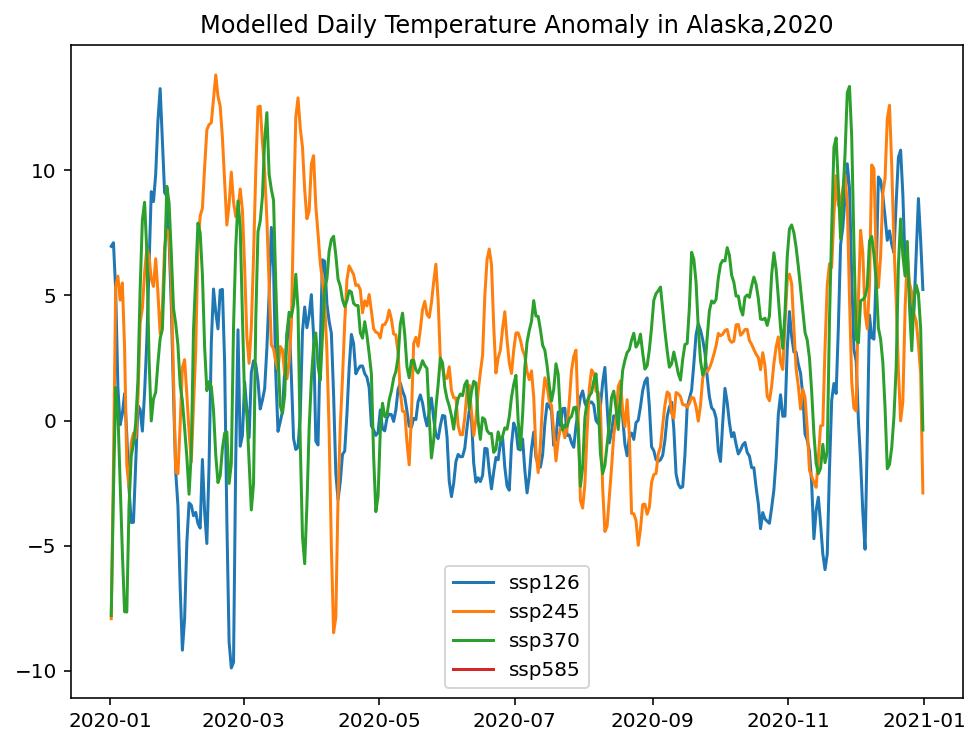

<Figure size 432x288 with 0 Axes>

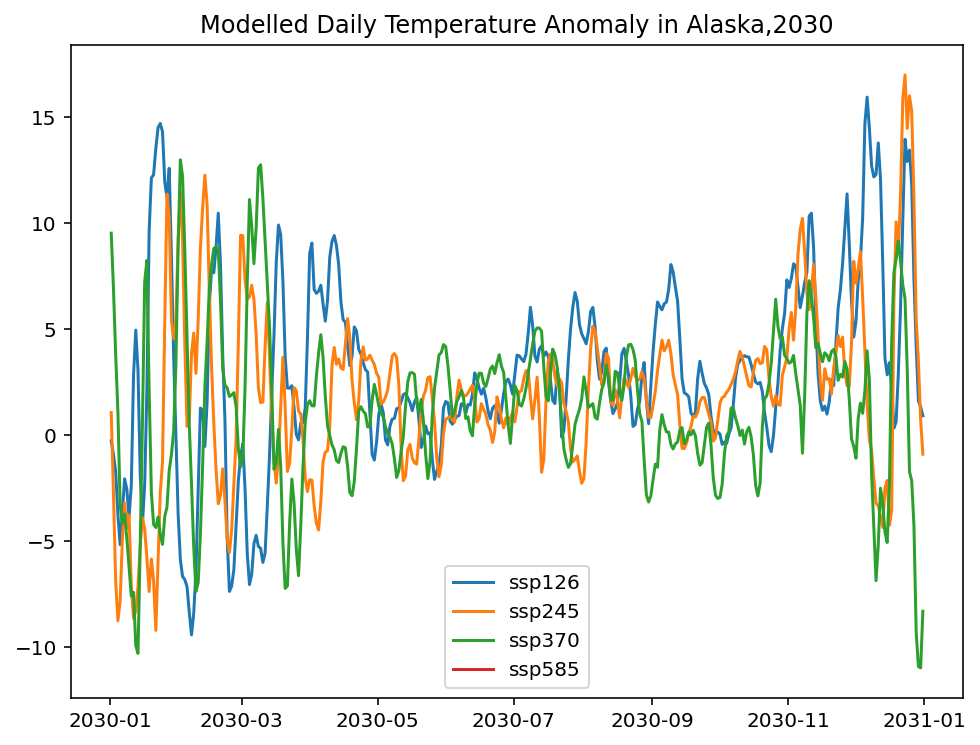

<Figure size 432x288 with 0 Axes>

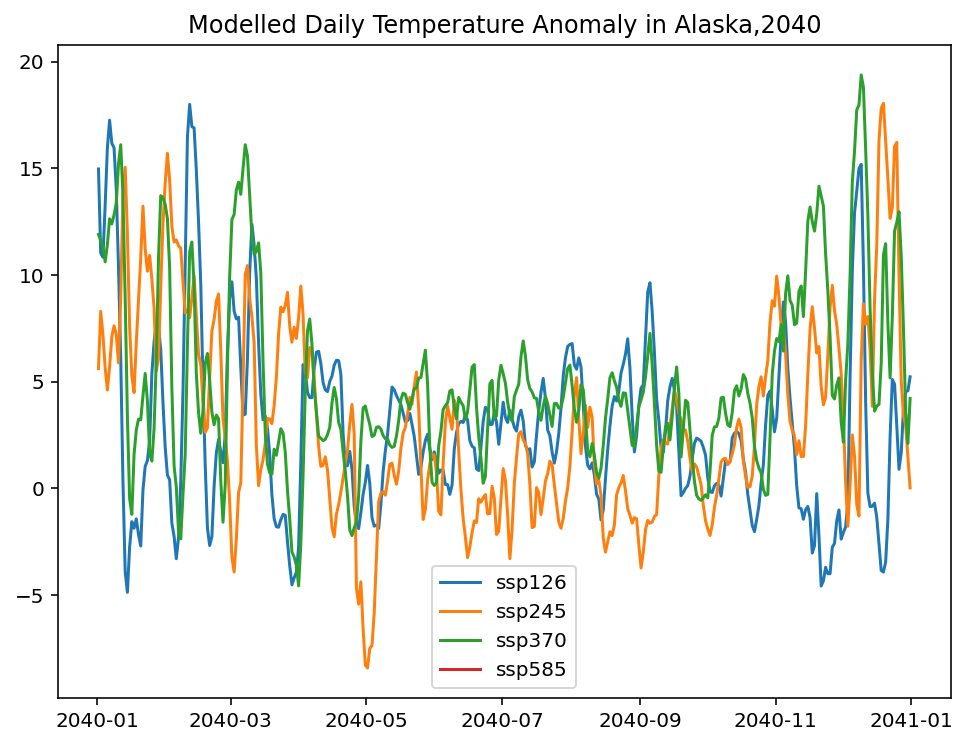

<Figure size 432x288 with 0 Axes>

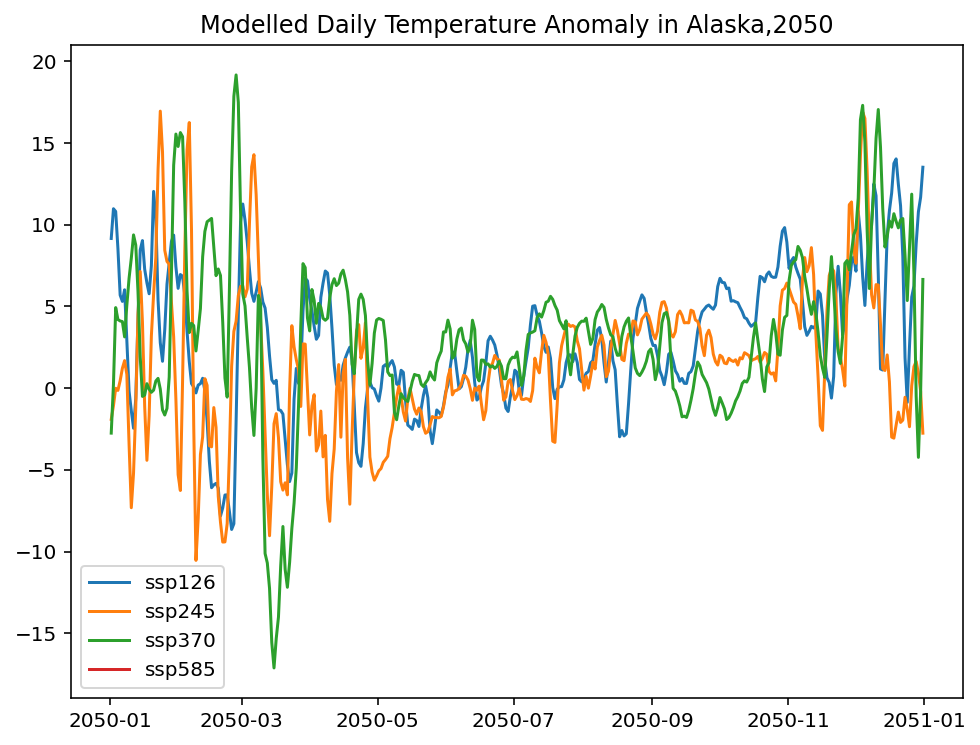

<Figure size 432x288 with 0 Axes>

In [12]:
def plot_daily_anomaly_by_year(year,msts):
    plt.figure(figsize=(8,6))
    for i in range(1,len(msts)):
        slicem = msts[i].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
        plt.plot(slicem['time'],slicem['tas'],label=models[i])
        #plt.xlim(19
    #plt.ylim(0)
    plt.title('Modelled Daily Temperature Anomaly in Alaska,'+str(year))
    plt.legend()
    plt.show()
    plt.savefig('./figures/daily_anomalies/dailyanomaly_alaska_'+str(year)+'.png')

years = (2020,2030,2040,2050)
for yr in years:
    plot_daily_anomaly_by_year(yr,akmsts)

In [ ]:
def plot_daily_anomaly_by_year(year):
    plt.figure(figsize=(8,6))
    for i in range(1,len(gmsts)):
        slicem = gmsts[i].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
        plt.plot(slicem['time'],slicem['tas'],label=models[i])
        #plt.xlim(19
    plt.ylim(0)
    plt.title('Modelled Daily Temperature Anomaly in '+str(year))
    plt.legend()
    plt.show()
    #plt.savefig('./figures/dailyanomaly'+str(year)+'.png')
years = (2020,2030,2040,2050)
for yr in years:
    plot_daily_anomaly_by_year(yr)

In [ ]:
#We now have modelled surface temperature  under tas_hist['tas'] corresponding to dates tas_hist['time']
def find_heatwaves(tas_anomaly):
    """
    this function finds heatwaves (defined poorly by Lulu to be 6 or more consecutive days above the MEAN     ANOMALY for the given year)
    """
    yr_heatwave_centers = []
    years = []
    for yr, tas_anomaly in tas_anomaly.groupby('time.year'):
        temps = tas_anomaly['tas']
        ann_avg_anomaly = np.nanmean(temps)
        heatwave_centers = []

        for i in range(3,362):
            num_days_above = 0
            for j in range (i-3,i+4):
                if temps[j] > ann_avg_anomaly:
                    num_days_above +=1
            if num_days_above >=6:
                heatwave_centers.append(i)
    
        # find if there is overlap between heatwaves
        new_heatwave_centers = []
        for i in range(len(heatwave_centers)-1):
            if (heatwave_centers[i+1]-heatwave_centers[i])<=3:
                # if overlap, replace with halfway between the two
                new_center = math.floor((heatwave_centers[i+1] + heatwave_centers[i])/2)
                new_heatwave_centers.append(new_center)
            else:
                new_heatwave_centers.append(heatwave_centers[i])
        yr_heatwave_centers.append(new_heatwave_centers)
        years.append(yr)
    return years, yr_heatwave_centers



In [ ]:
all_years = []
all_heatwaves = []
for i in range(len(akmsts)):
    print('calculating heatwaves for model '+str(i+1))
    years, ak_heatwaves = find_heatwaves(akmsts[i])
    all_years.append(years)
    all_heatwaves.append(ak_heatwaves)

In [ ]:
# let's find and plot how many heatwaves there are per year (RELATIVE TO ANNUAL AVG ANOMALY )
def find_heatwaves_per_year(years, yr_heatwave_centers):
    yr_heatwaves = [len(center_list) for center_list in yr_heatwave_centers]
    plt.figure(figsize=(8,6))
    plt.plot(years,yr_heatwaves)
    plt.title('Number of Heatwaves Per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of heatwaves (>6 days above mean yearly anomaly)')
    plt.show()
    return yr_heatwaves

def plot_heatwaves_per_year(list_models,list_years, list_yr_heatwave_centers):
    plt.figure(figsize=(8,6))
    for i in range(len(list_years)):
        yr_heatwave_centers = list_yr_heatwave_centers[i]
        years = list_years[i]
        yr_heatwaves = [len(center_list) for center_list in yr_heatwave_centers]
        plt.plot(years,yr_heatwaves,label=list_models[i])
    plt.title('Number of Heatwaves Per Year')
    plt.xlim(1980,2100)
    plt.xlabel('Year')
    plt.ylabel('Number of heatwaves (>6 days above mean yearly anomaly)')
    plt.legend()
    plt.show()



In [ ]:
plot_heatwaves_per_year(models,all_years, all_heatwaves)

In [ ]:
def find_num_days_1deg_anomaly(tas_anomaly,ndeg):
    """
    this function finds the number of days per year that are greater than 1 degree anomaly above the          1981-2010 mean temperature for that day of the year. 
    """
    yr_num_days_above = []
    years = []
    for yr, tas_anomaly in tas_anomaly.groupby('time.year'):
        temps = tas_anomaly['tas']
        num_days_above_1deg = 0
        for i in range(len(temps)):
            if temps[i]>ndeg:
                num_days_above_1deg +=1
        yr_num_days_above.append(num_days_above_1deg)
        years.append(yr)
    return  years, yr_num_days_above

In [ ]:
all_years = []
all_num_days = []
for i in range(len(akmsts)):
    print('calculating num days for model '+str(i+1))
    years, num_days = find_num_days_1deg_anomaly(akmsts[i],1)
    all_years.append(years)
    all_num_days.append(num_days)

all_years_2 = []
all_num_days_2 = []
for i in range(len(akmsts)):
    print('calculating num days for model '+str(i+1))
    years, num_days = find_num_days_1deg_anomaly(akmsts[i],2)
    all_years_2.append(years)
    all_num_days_2.append(num_days)


In [ ]:
plt.figure(figsize=(8,6))
for i in range(len(all_years_2)):
    years = all_years_2[i]
    yr_numdays = all_num_days_2[i]
    plt.plot(years,yr_numdays,label=models[i])
plt.title('Number of Days Per Year >2º anomaly above 1981-2010 mean')
plt.xlim(1980,2100)
plt.xlabel('Year')
plt.ylabel('Number of days per year > 2º anomaly above mean')
plt.legend()
plt.savefig('./figures/daily_anomalies/numdaysperyear_>2deg.png')
plt.show()


In [30]:
print(tas_anomaly_hist.variables["tas"].shape)
print(lats.shape, lons.shape)

(10957, 144, 192)
(144,) (192,)


In [33]:
lats = tas_anomaly_hist.variables["lat"][:]
lons = tas_anomaly_hist.variables["lon"][:]
temps = tas_anomaly_hist.variables["tas"][100][:][:]
mapLon, mapLat = np.meshgrid(lons,lats)
#tas_anomaly_hist

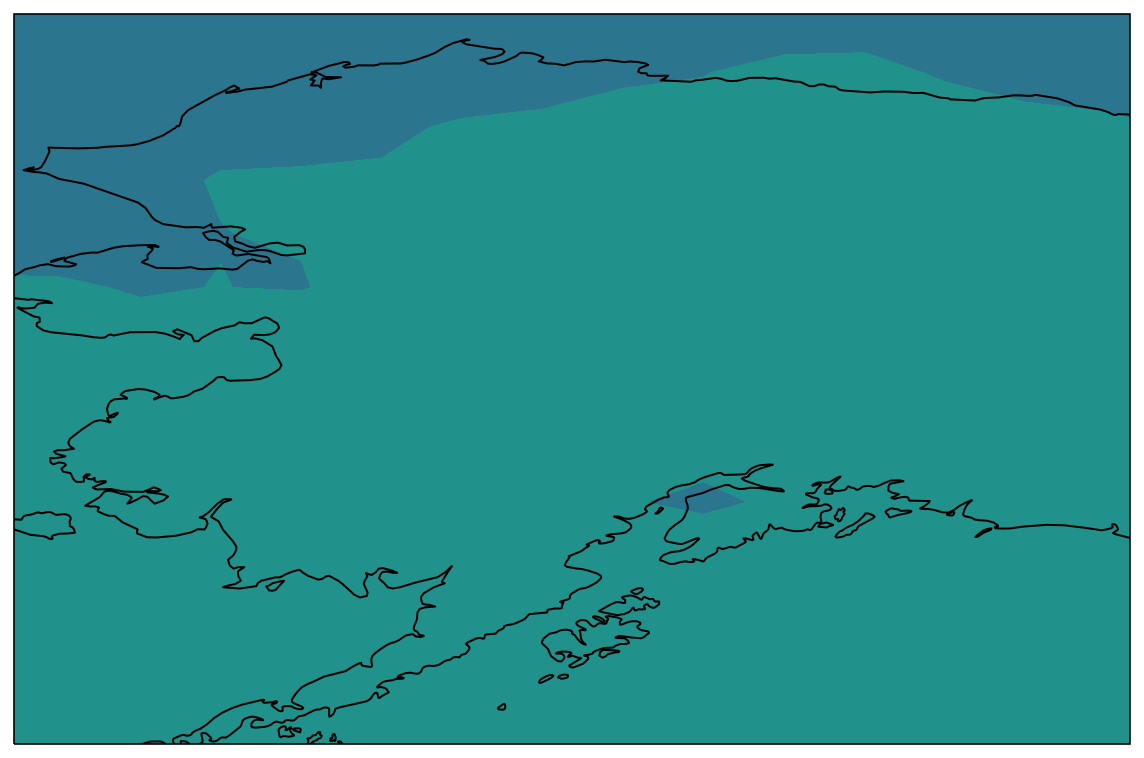

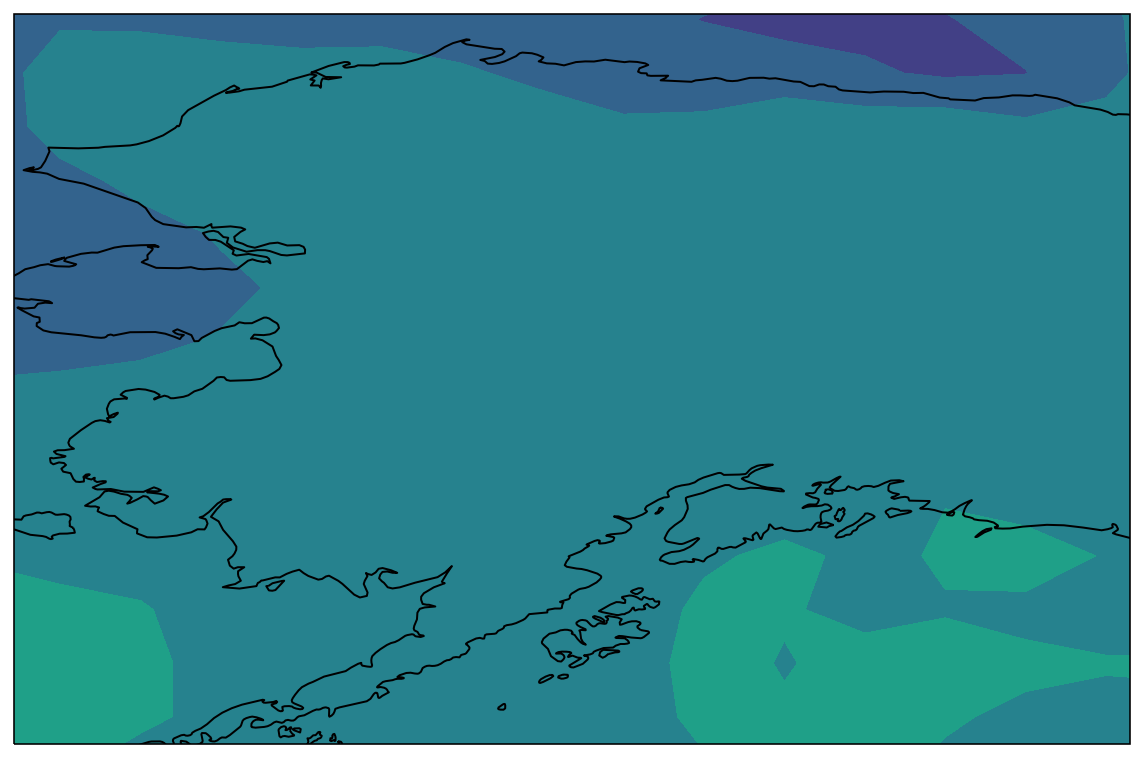

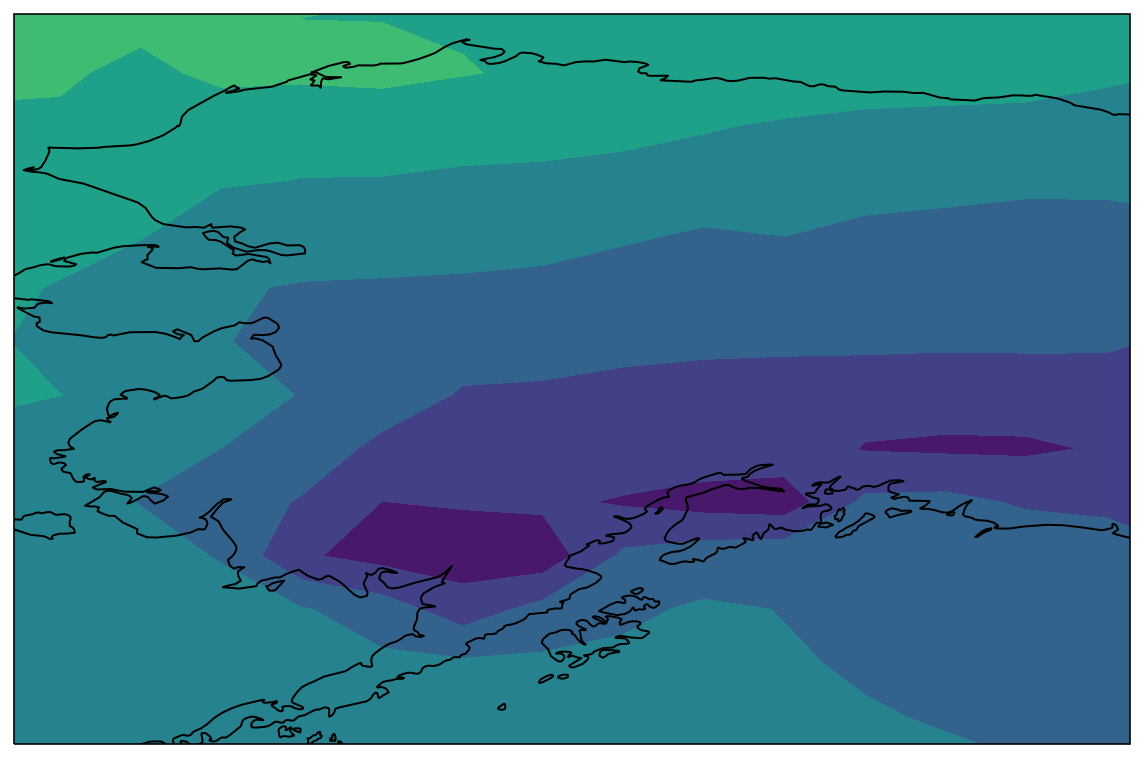

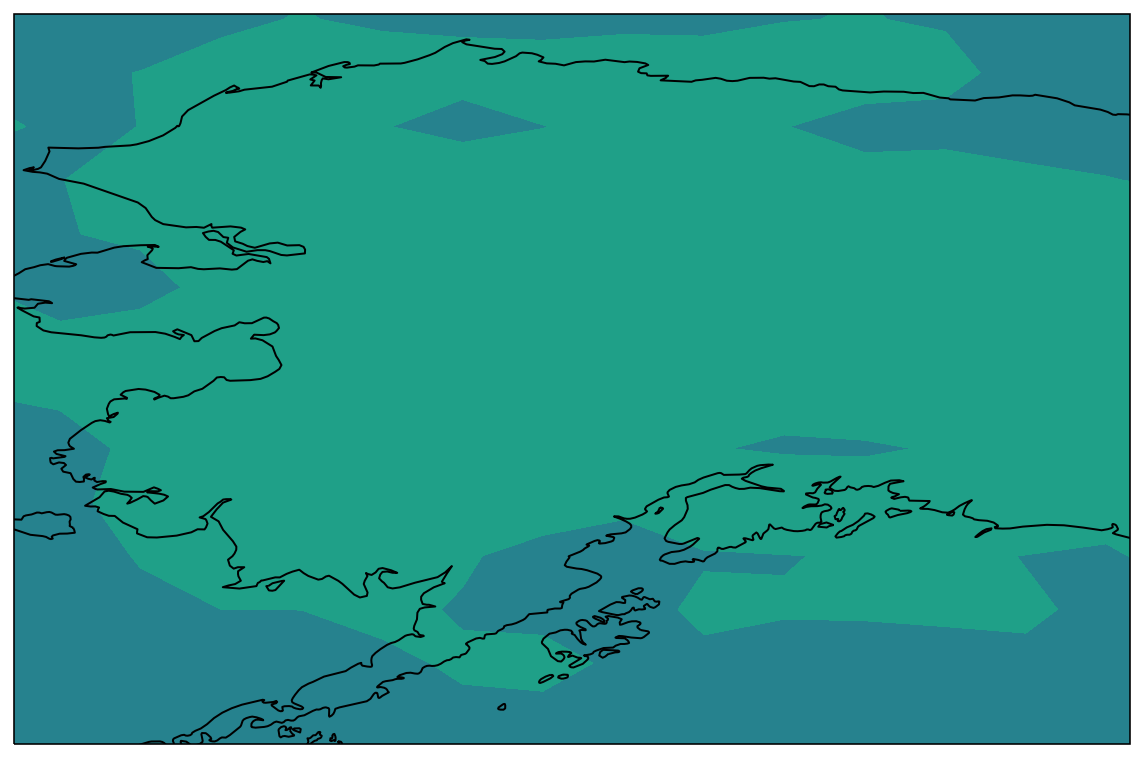

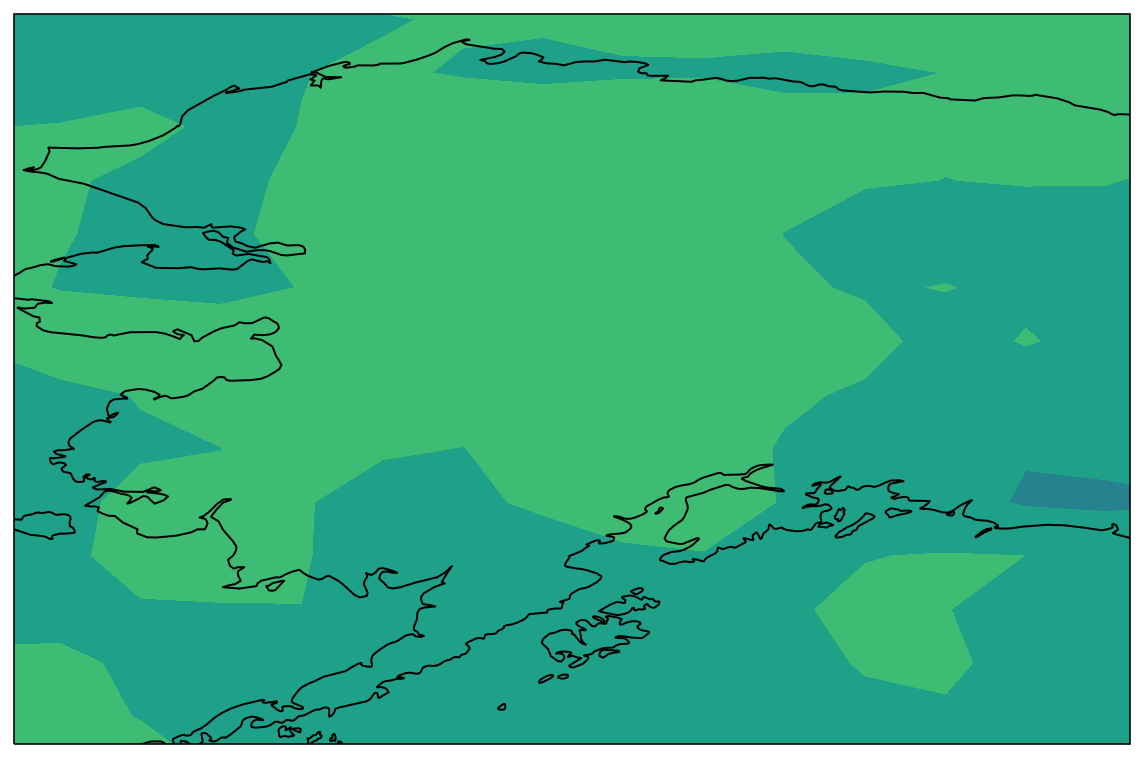

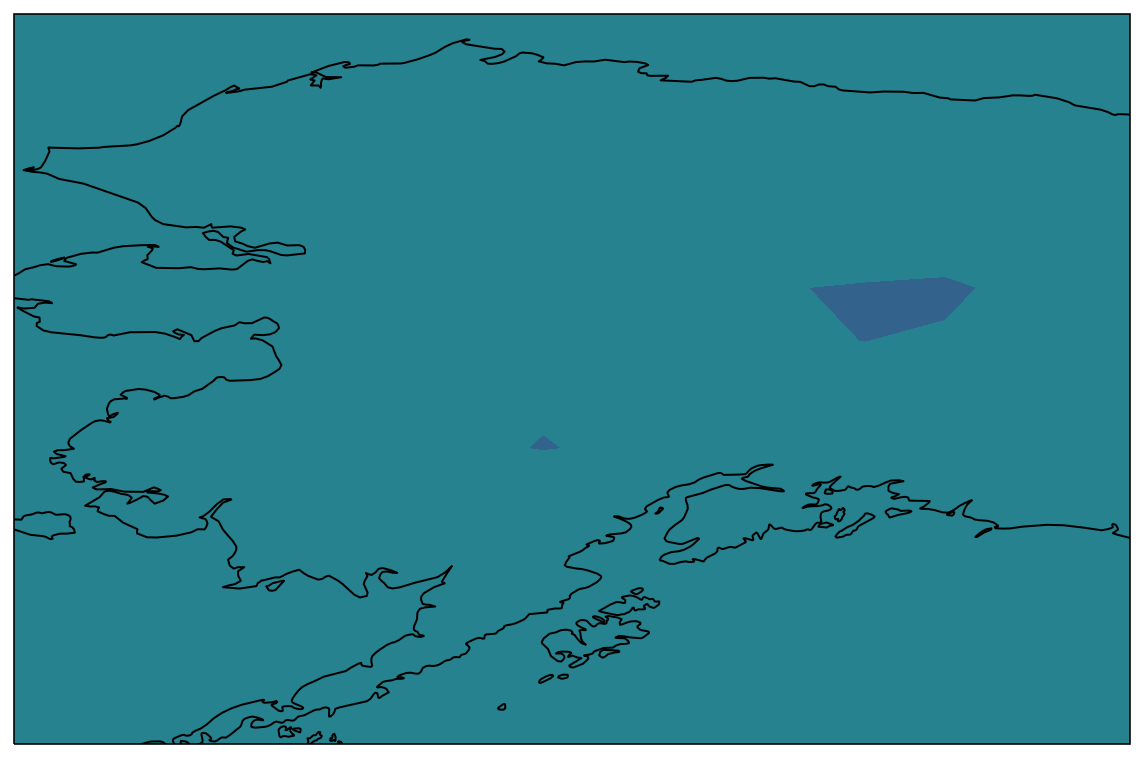

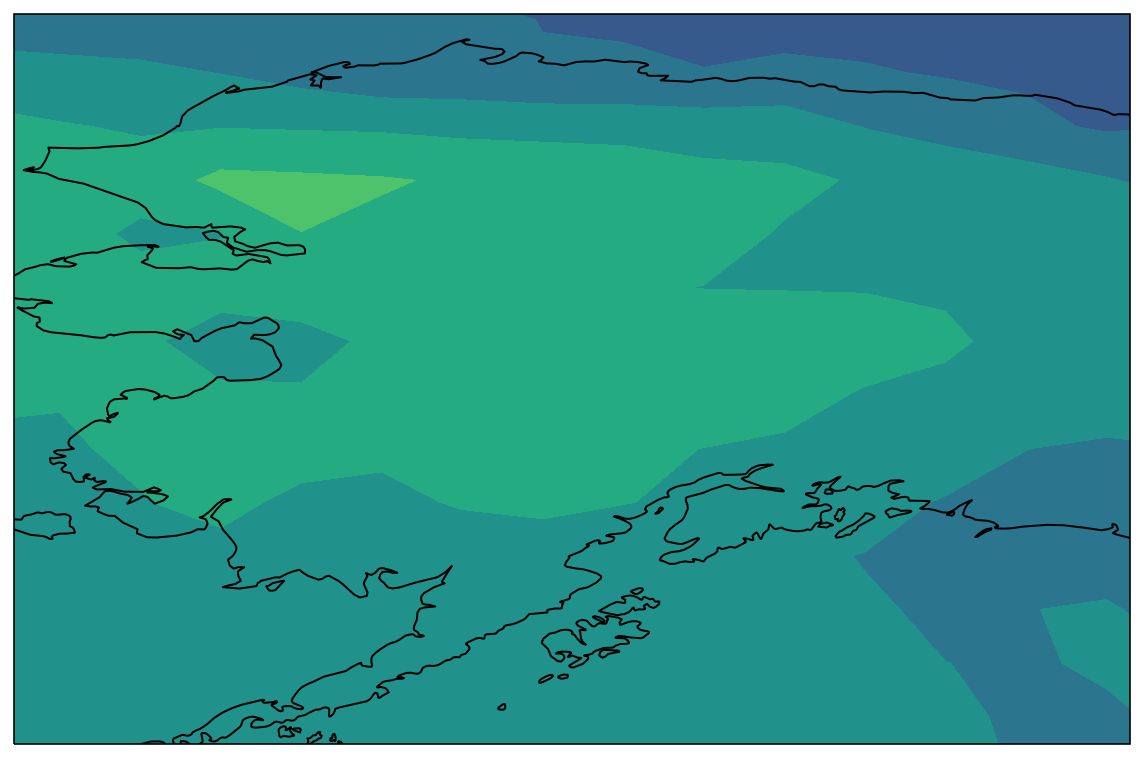

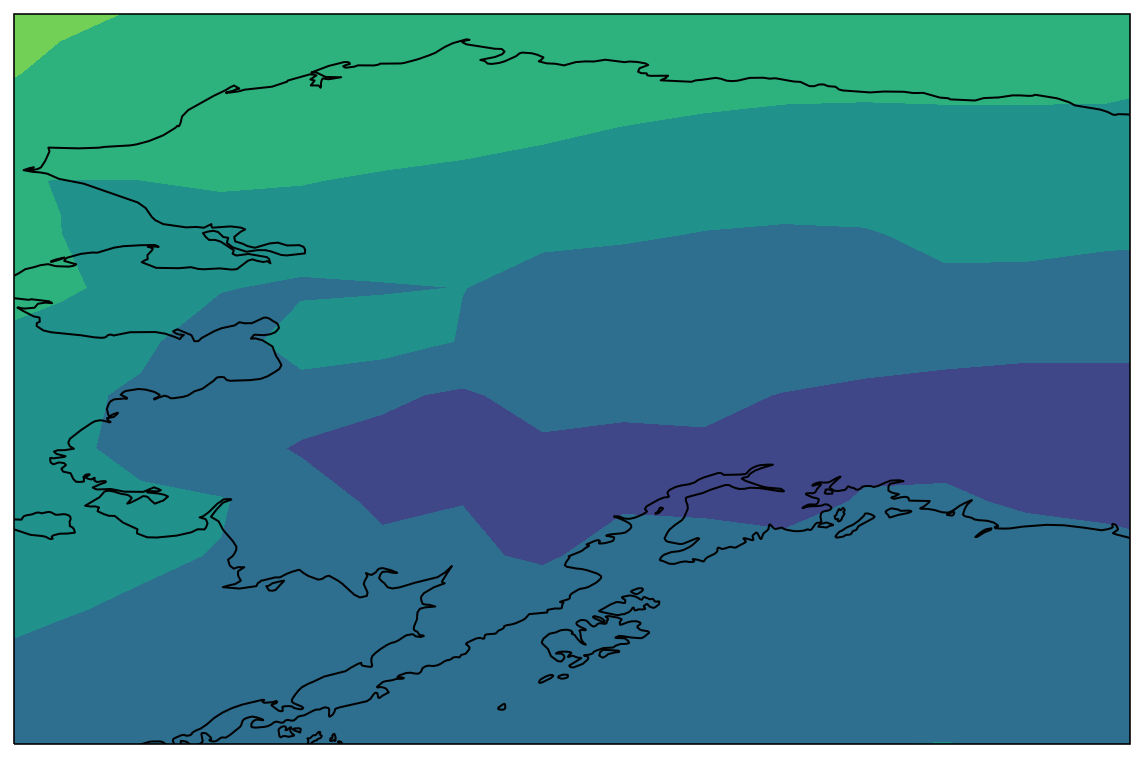

In [61]:
times = [500,1000,1500,2000,2500,2800,2900,3000]
for t in times:
    temps = tas_anomaly_hist.variables["tas"][t][:][:]
    plt.figure(figsize=(10,7))
    proj = ccrs.PlateCarree()
    m1 = plt.axes(projection=proj)
    m1.set_global()
    m1.coastlines()
    plt.contourf(mapLon, mapLat, temps,transform=proj)
    m1.set_extent([-167,-141,55,72],crs=proj)
    plt.show()
#m1.add_feature(cf.LAND)
#m1.add_feature(cf.OCEAN)
#m1.add_feature(cf.BORDERS,ls=':')
#m1.add_feature(cf.OCEAN)
#m1.stock_img()
#m1.set_extent([-167,-141,55,72],crs=proj)
#tas_anomaly_hist